In [ ]:
pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

  Cloning https://github.com/mimoralea/gym-walk to /tmp/pip-install-_7i6db7m/gym-walk_5f8255fc7c8a4ed893d682c8dc0d3448
  Running command git clone --filter=blob:none --quiet https://github.com/mimoralea/gym-walk /tmp/pip-install-_7i6db7m/gym-walk_5f8255fc7c8a4ed893d682c8dc0d3448
  Resolved https://github.com/mimoralea/gym-walk to commit 5999016267d6de2f5a63307fb00dfd63de319ac1
  Preparing metadata (setup.py) ... done
  Created wheel for gym-walk: filename=gym_walk-0.0.2-py3-none-any.whl size=4059 sha256=a9be878cba83ed4364be982aebe623448df11de4228773d7563425fdea426513
  Stored in directory: /tmp/pip-ephem-wheel-cache-yd0hquhh/wheels/24/fe/c4/0cbc7511d29265bad7e28a09311db3f87f0cafba74af54d530
Successfully built gym-walk


In [ ]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [ ]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [ ]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [ ]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [ ]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [ ]:
def print_action_value_function(Q,
                                optimal_Q=None,
                                action_symbols=('<', '>'),
                                prec=3,
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [ ]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q,
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret

            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)

            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100,
                        np.mean(episode_reward),
                        np.mean(episode_regret)))
    return results

In [ ]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=True, dtype=np.int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env,
                gamma=gamma,
                pi=lambda s: pi[s],
                goal_state=goal_state,
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma

In [ ]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [ ]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)

    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [ ]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [ ]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
gamma = 0.99
n_episodes = 3000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', '>')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


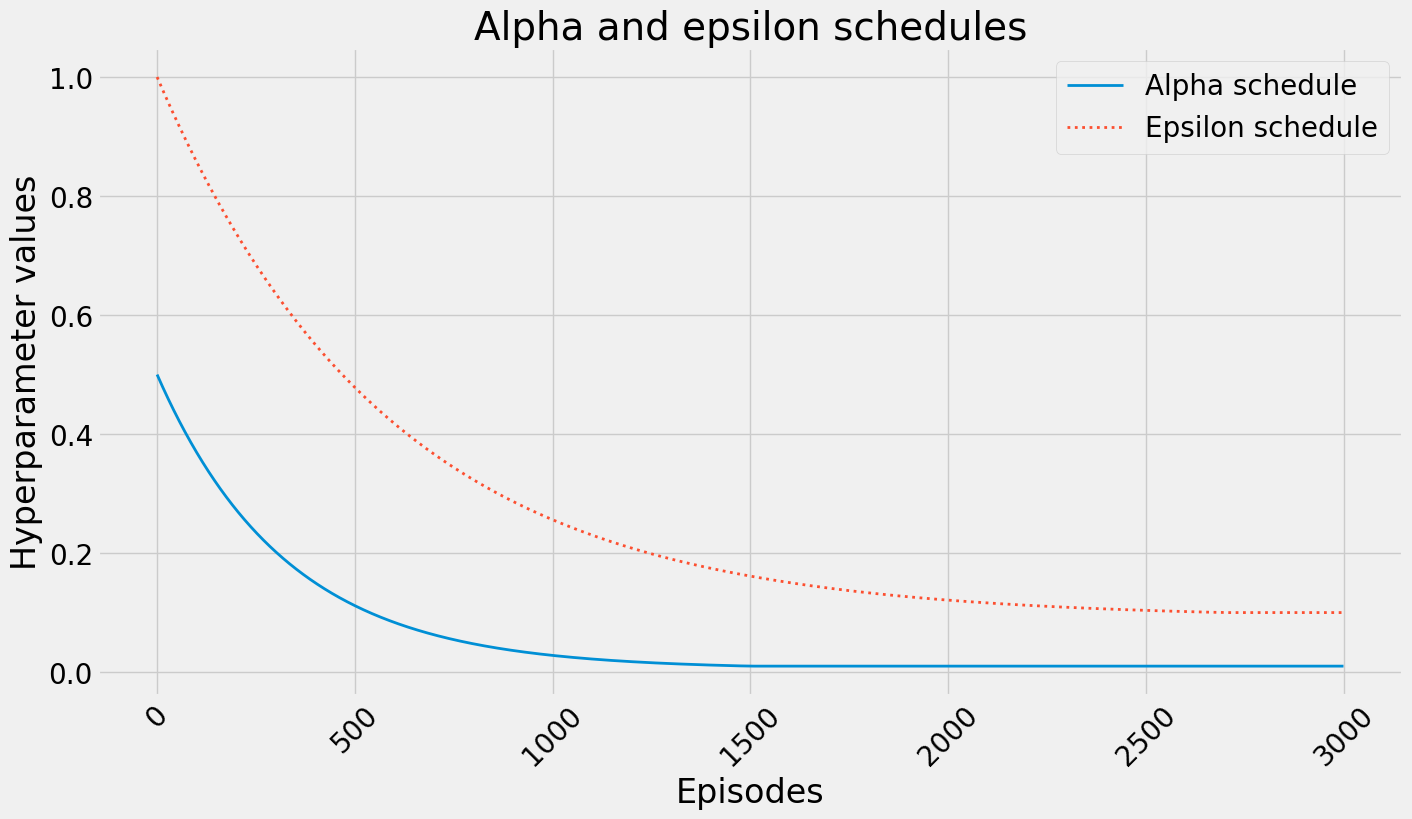

In [ ]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes),
         '-', linewidth=2,
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes),
         ':', linewidth=2,
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

In [ ]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q,
                            None,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╕
│   s │     < │     > │
╞═════╪═══════╪═══════╡
│   0 │ 0     │ 0     │
├─────┼───────┼───────┤
│   1 │ 0.312 │ 0.564 │
├─────┼───────┼───────┤
│   2 │ 0.67  │ 0.763 │
├─────┼───────┼───────┤
│   3 │ 0.803 │ 0.845 │
├─────┼───────┼───────┤
│   4 │ 0.864 │ 0.889 │
├─────┼───────┼───────┤
│   5 │ 0.901 │ 0.922 │
├─────┼───────┼───────┤
│   6 │ 0.932 │ 0.952 │
├─────┼───────┼───────┤
│   7 │ 0.961 │ 0.981 │
├─────┼───────┼───────┤
│   8 │ 0     │ 0     │
╘═════╧═══════╧═══════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.8672. Regret of 0.0000


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


In [ ]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

In [ ]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0,
                            max_steps,
                            num=max_steps,
                            base=gamma,
                            endpoint=False)
    alphas = decay_schedule(init_alpha,
                           min_alpha,
                           alpha_decay_ratio,
                           n_episodes)
    epsilons = decay_schedule(init_epsilon,
                              min_epsilon,
                              epsilon_decay_ratio,
                              n_episodes)
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    for e in tqdm(range(n_episodes), leave=False):

        trajectory = generate_trajectory(select_action,
                                         Q,
                                         epsilons[e],
                                         env,
                                         max_steps)
        visited = np.zeros((nS, nA), dtype=bool)
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [ ]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

<ipython-input-19-a266861b13d1>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm(SEEDS, desc='All seeds', leave=True):


All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
print('Name: KANISHKAR  M  Register Number: 212222240044 ')
print_state_value_function(V_mc, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

Name: KANISHKAR  M  Register Number: 212222240044 
State-value function found by FVMC:
|           | 01  0.502 | 02 0.7282 | 03 0.8219 | 04 0.8735 | 05 0.9146 | 06 0.9457 | 07 0.9797 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.06 | 02  -0.03 | 03  -0.02 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0256

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.175 │ 0.502 │ 0.312 │ 0.564 │   0.137 │   0.062 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.557 │ 0.728 │ 0.67  │ 0.763 │  

In [ ]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.5,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    # Write your code here
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) if np.random.random() > epsilon else np.random.randint(len(Q[state]))

    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio,
        n_episodes)

    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio,
        n_episodes)

    for e in tqdm(range(n_episodes), leave=False):
      state, done = env.reset(), False
      action = select_action(state, Q, epsilons[e])

      while not done:
        next_state, reward, done, _ = env.step(action)
        next_action = select_action(next_state,
                                    Q,
                                    epsilons[e])
        td_target = reward + gamma * Q[next_state][next_action] * (not done)

        td_error = td_target - Q[state][action]
        Q[state][action] = Q[state][action] +  alphas[e] * td_error

        state, action = next_state, next_action

      Q_track[e] = Q
      pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))} [s]

    return Q, V, pi, Q_track, pi_track

In [ ]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

<ipython-input-26-421377be1a07>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm(SEEDS, desc='All seeds', leave=True):


All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
print('Name: KANISHKAR M Register Number: 212222240044 ')
print_state_value_function(V_sarsa, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by Sarsa:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Sarsa action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

Name: KANISHKAR M Register Number: 212222240044 
State-value function found by Sarsa:
|           | 01 0.4348 | 02 0.6696 | 03 0.7941 | 04 0.8659 | 05 0.9068 | 06 0.9417 | 07 0.9777 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.13 | 02  -0.09 | 03  -0.05 | 04  -0.02 | 05  -0.02 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0566

Sarsa action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╕
│   s │     < │     > │   * < │   * > │   err < │   err > │
╞═════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │   0     │   0     │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   1 │ 0.211 │ 0.435 │ 0.312 │ 0.564 │   0.101 │   0.129 │
├─────┼───────┼───────┼───────┼───────┼─────────┼─────────┤
│   2 │ 0.477 │ 0.67  │ 0.67  │ 0.763 │  

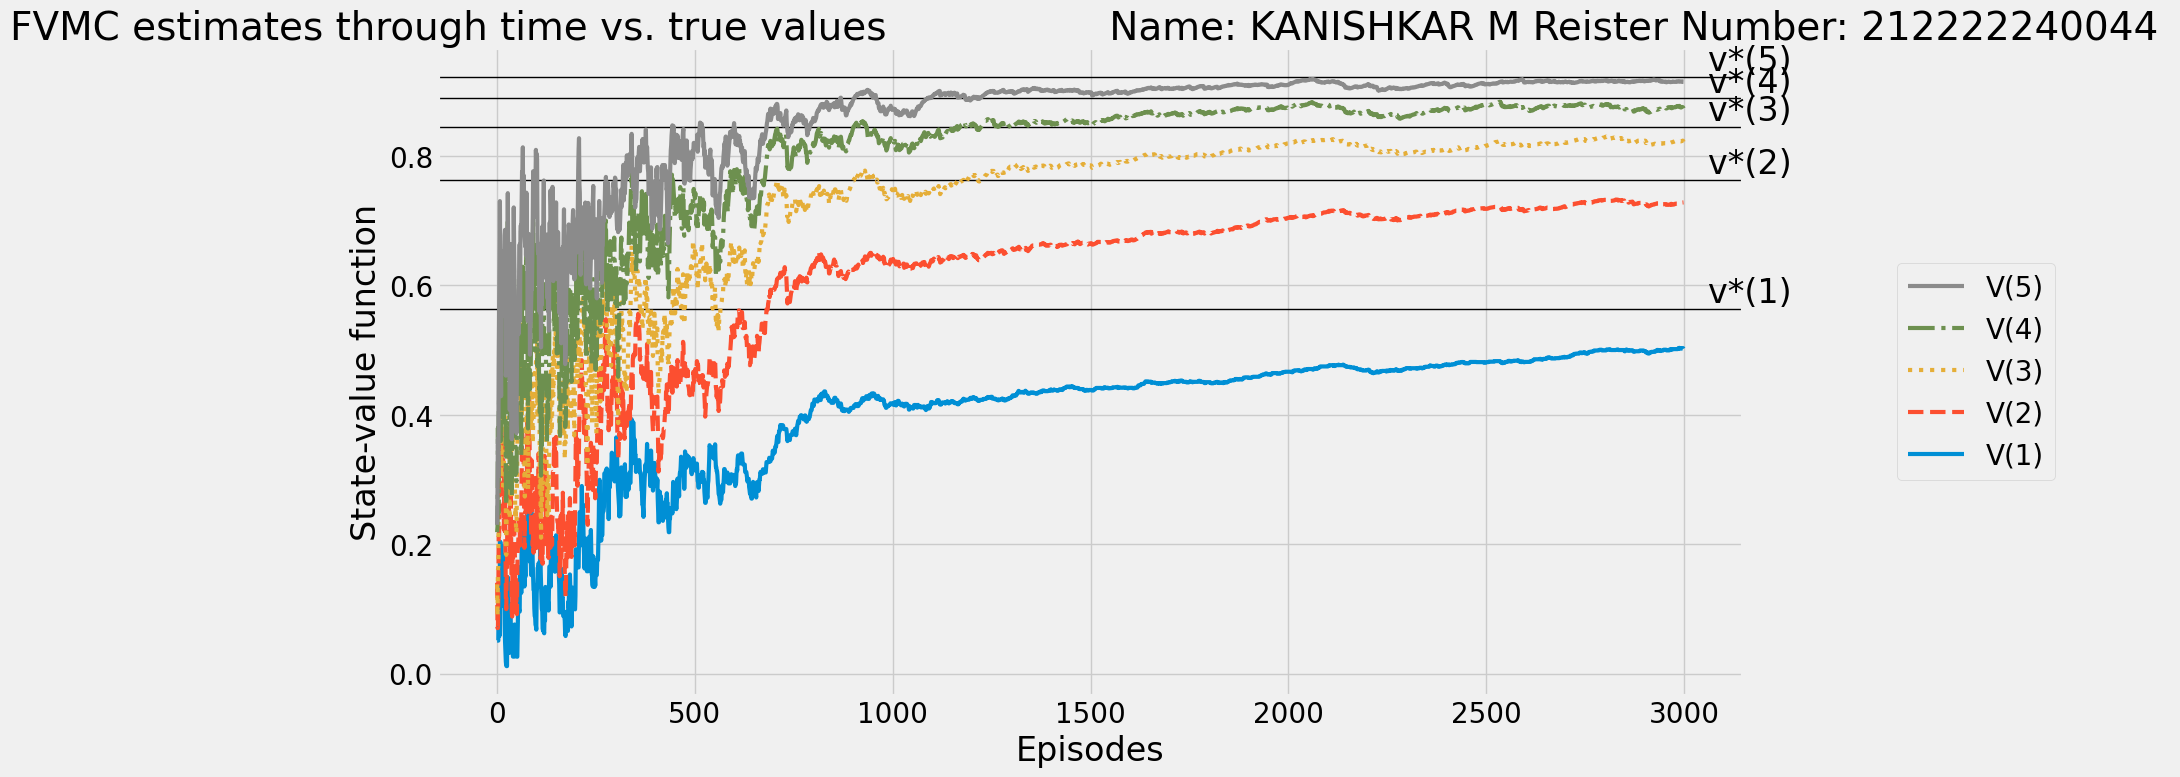

In [ ]:
plot_value_function(
    'FVMC estimates through time vs. true values                  Name: KANISHKAR M Reister Number: 212222240044 ',
    np.max(Q_track_mc, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

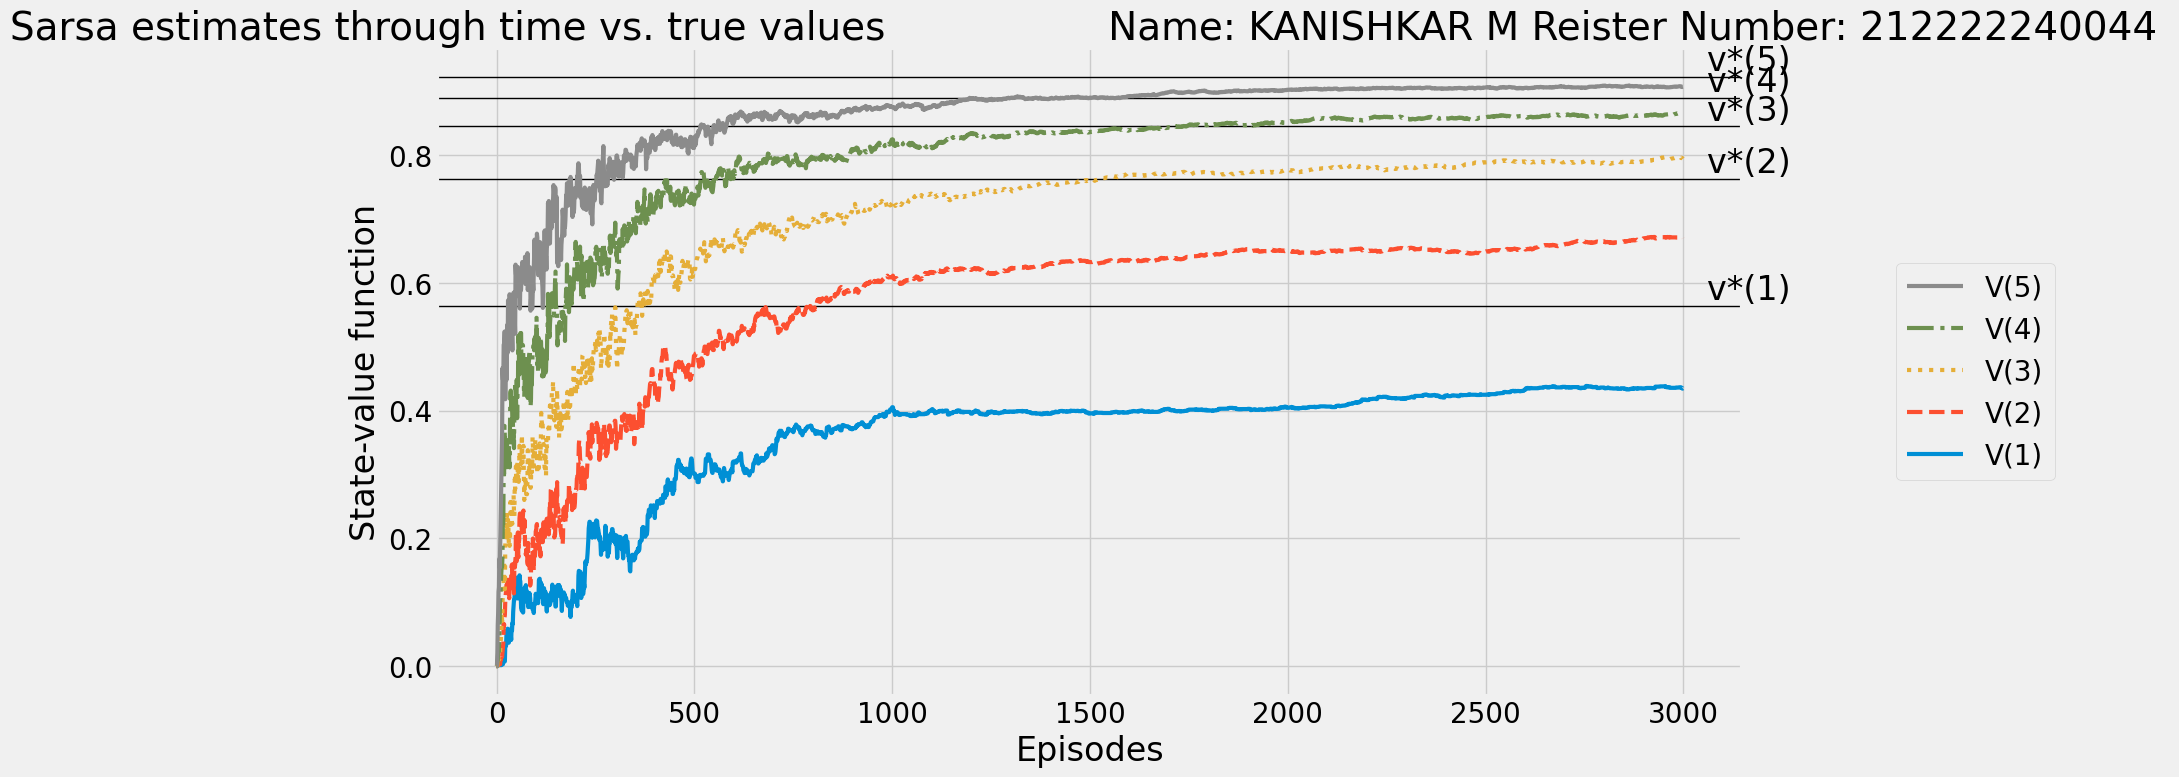

In [ ]:
plot_value_function(
    'Sarsa estimates through time vs. true values                  Name: KANISHKAR M Reister Number: 212222240044 ',
    np.max(Q_track_sarsa, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)